# Obtain plots of particular latent states on RAW lfp signals

## Libs and load data for

Data required :

From trained model (mcRBM output)
*   obsKeys.npz
*   uniqueStates.npz
*   latentStates.npz

From test post trial (mcRBM output)
*   obsKeyspt.npz
*   uniqueStatespt.npz
*   latentStatespt.npz
*   raw hpc mat
*   raw pfc mat
---



# Load data

In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
fs = 1000
window_length = fs*2
epoch_length = int(window_length/fs)

In [ ]:
# Load data from trained model
latent_states = np.load('latentStates.npz')
unique_states = np.load('uniqueStates.npz')
obs_keys = np.load('obsKeys.npz')

# Load data from test on post trial 5 (pt5)
latent_states_pt = np.load('latentStatespt.npz')
unique_states_pt = np.load('uniqueStatespt.npz')
obs_keys_pt = np.load('obsKeyspt.npz')

In [ ]:
# Get inferred states from model and from test
inferredStates = latent_states['inferredStates']
inferredStates_pt = latent_states_pt['inferredStates']

In [ ]:
# Load states from pt5 (artefact already marked at 0)
states = inferredStates_pt[:,1]
upsampled_states = np.repeat(states, 2*fs) # Upsample states to match other data

# Loading HPC raw data and truncate the end to get exact match
hpc_data = loadmat('Rat3_SD14_HC_3_posttrial5_HPC')
hpc_data = hpc_data['HPC']
hpc_data = hpc_data[8*fs:]
raw_hpc = np.ravel(hpc_data)
raw_hpc = raw_hpc[0:len(upsampled_states)]

# Loading PFC raw data and truncate the end to get exact match
pfc_data = loadmat('Rat3_SD14_HC_3_posttrial5_PFC')
pfc_data = pfc_data['PFC']
pfc_data = pfc_data[8*fs:]
raw_pfc = np.ravel(pfc_data)
raw_pfc = raw_pfc[0:len(upsampled_states)]

# Mark as NaN all elements that are either artefact or transitional states(TS) - so that these don't appear in the plots
indices = np.where((upsampled_states != 1) & (upsampled_states != 3) & (upsampled_states != 5))[0]  # Get indices of all epochs that are not in the inferred states epochs (score = 0 and 4)
raw_hpc[indices] = np.nan
raw_pfc[indices] = np.nan
upsampled_states[indices] = 0

# Select latent states and load data

## Getting latent states arrays and downsampling for plots

In [ ]:
# Aligning latent state data with the raw data
upsampled_latent_states = np.repeat(inferredStates_pt, 2*fs, axis = 0)

In [ ]:
# Finding the indices epochs belonging to target latent states
a = 49   # Imput the latent states' indices (Make sure to check if length is as expected)
b = 8

indices_1 = np.where(upsampled_latent_states[:, 0] == a)[0]
indices_2 = np.where(upsampled_latent_states[:, 0] == b)[0]

In [ ]:
print('Epochs in latent ', a, ' : ' , len(indices_1)/(2*fs))
print('Epochs in latent ', b, ' : ' , len(indices_2)/(2*fs))

Epochs in latent  49  :  16.0
Epochs in latent  8  :  33.0


In [ ]:
# Preparing arrays to plot
hpc_1 = np.copy(raw_hpc)
pfc_1 = np.copy(raw_pfc)
hpc_2 = np.copy(raw_hpc)
pfc_2 = np.copy(raw_pfc)

mask_1 = np.ones_like(hpc_1, dtype=bool)
mask_2 = np.ones_like(hpc_2, dtype=bool)

mask_1[indices_1] = False
mask_2[indices_2] = False

hpc_1[mask_1] = np.nan
pfc_1[mask_1] = np.nan

hpc_2[mask_2] = np.nan
pfc_2[mask_2] = np.nan

# Downsampling (So that we can plot intervals of len ~ 400 secs)
raw_hpc = raw_hpc[::10]
hpc_1 = hpc_1[::10]
pfc_1 = pfc_1[::10]

raw_pfc = raw_pfc[::10]
hpc_2 = hpc_2[::10]
pfc_2 = pfc_2[::10]

upsampled_latent_states = upsampled_latent_states[::10]

new_fs = int(fs/10) # Let's not forget to set a new downsampled sampling frequency

## Plots

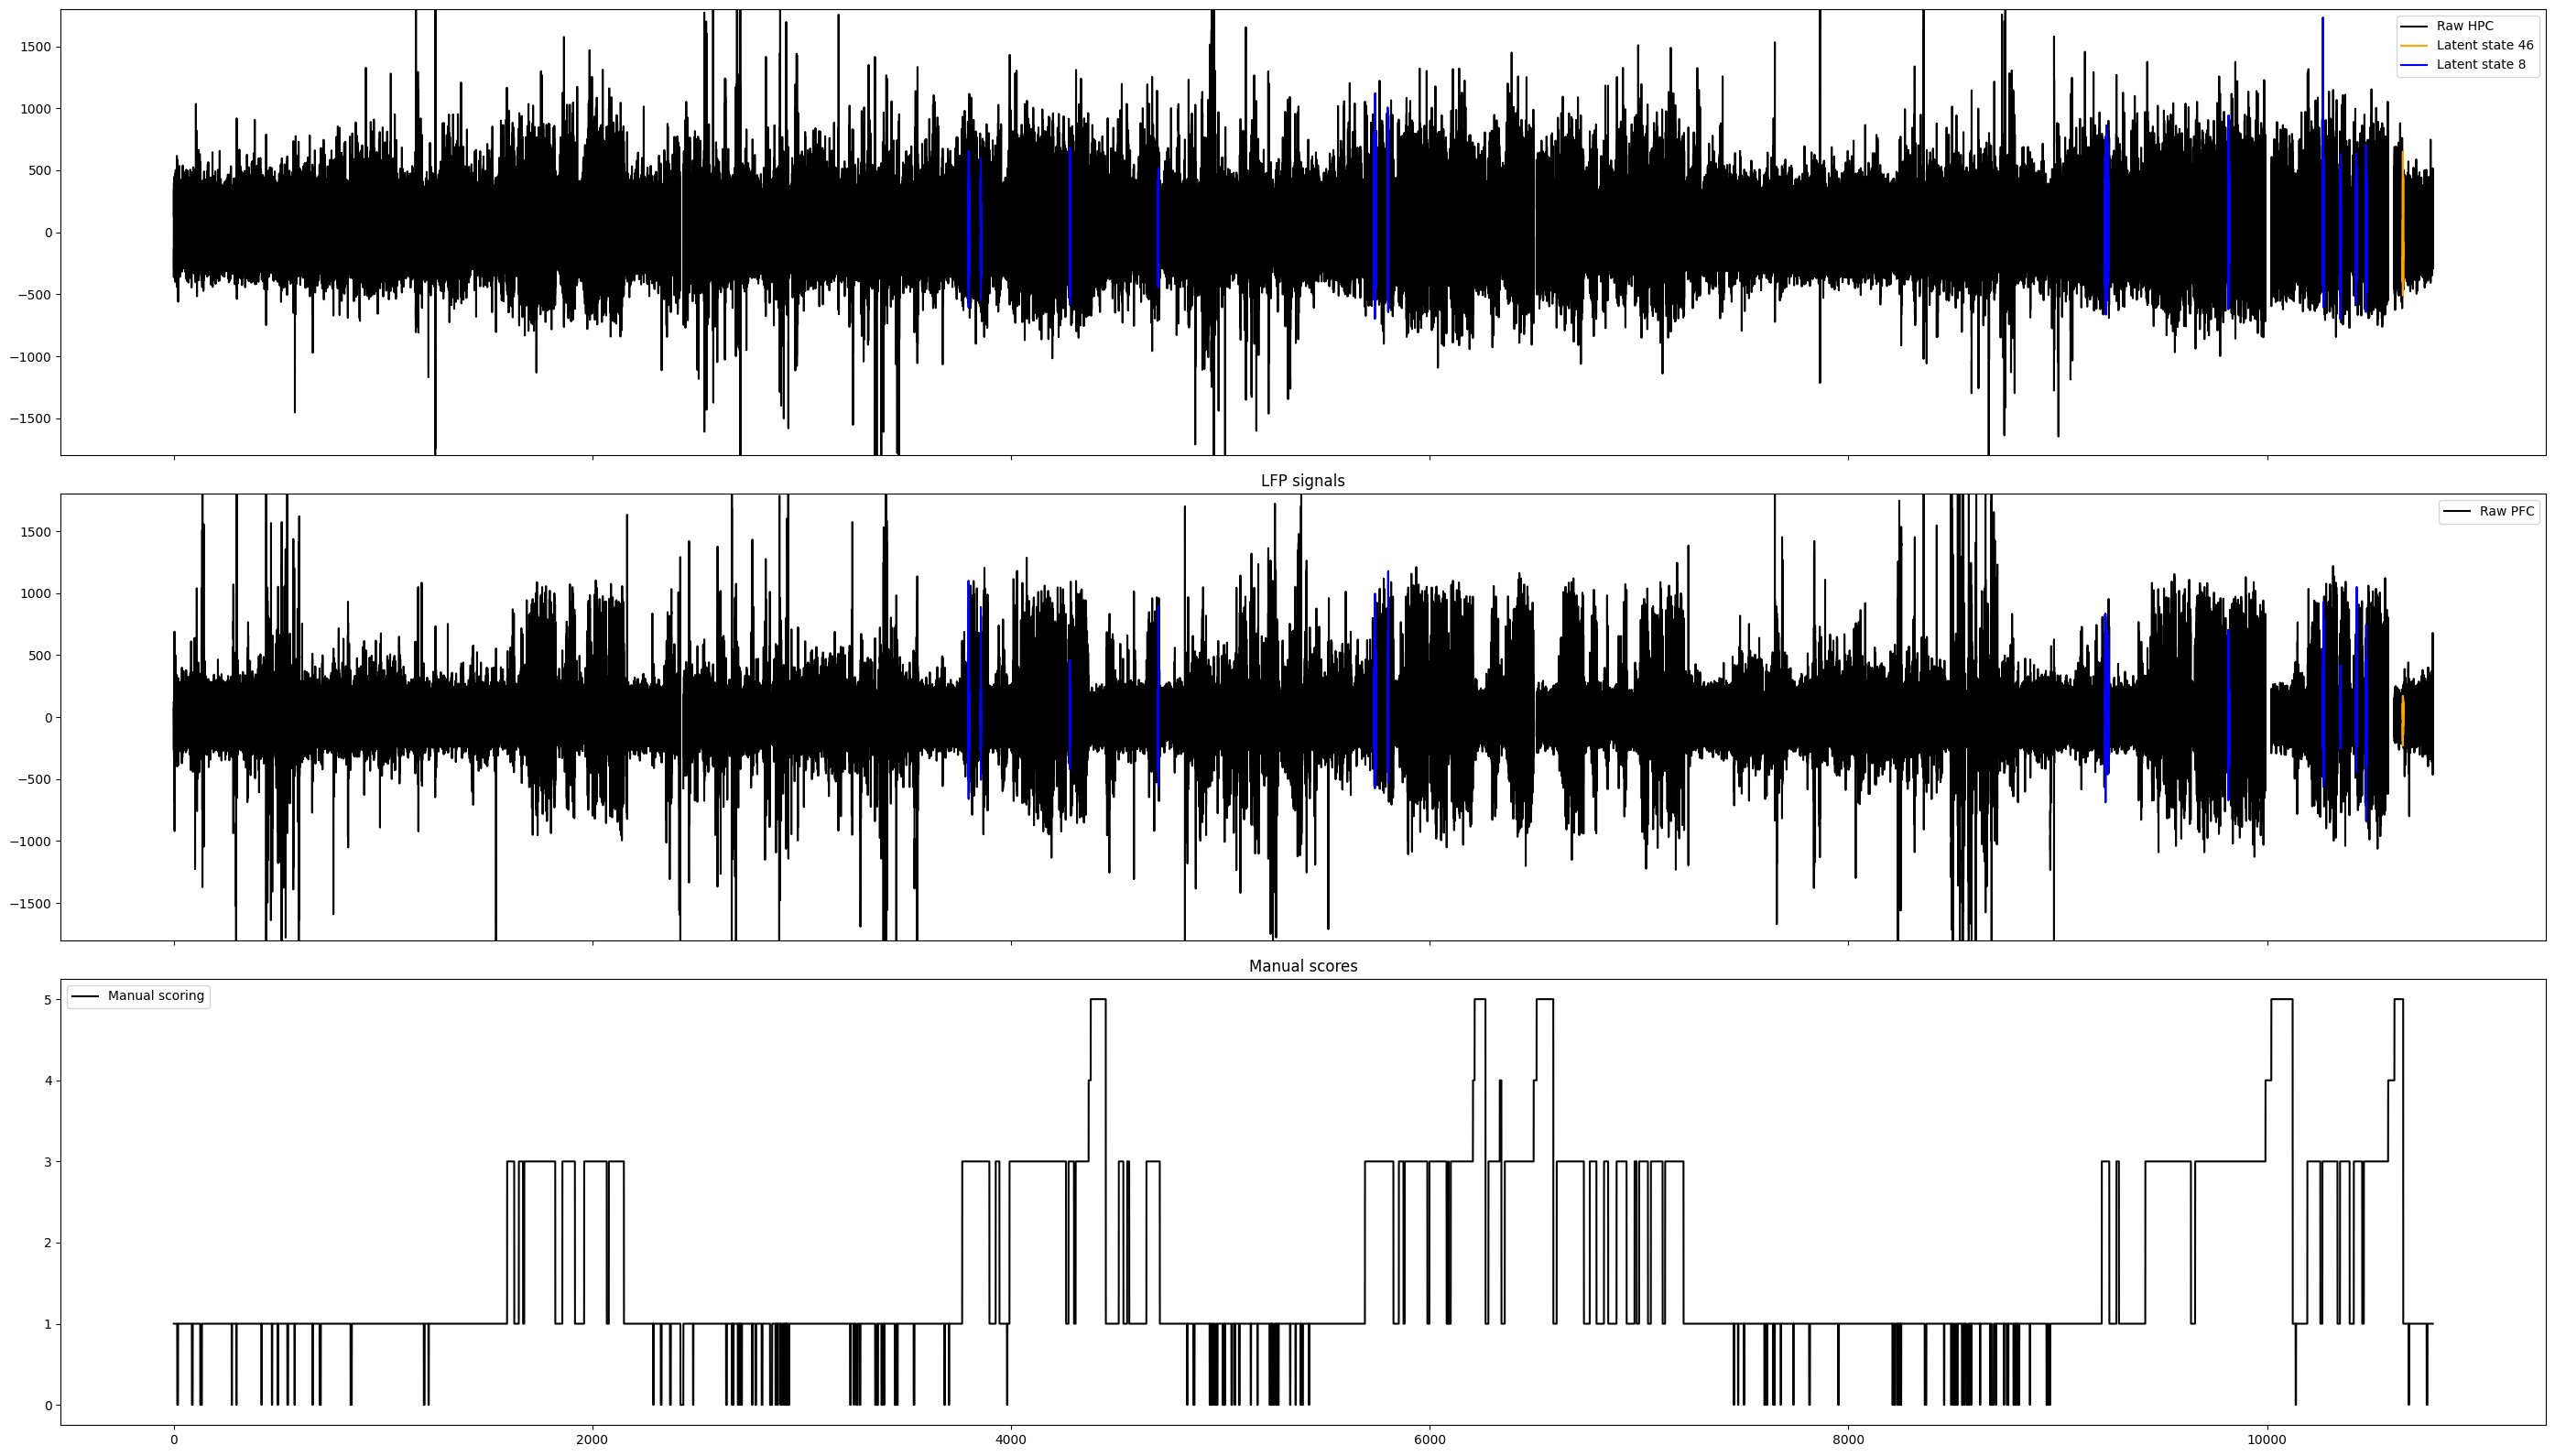

In [ ]:
x = np.arange(len(raw_hpc))/new_fs
times = np.arange(0, len(x))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))                                           # Plot whole LFP signals and manual scores to get an overall view of target areas - cf zoom on these areas below

# Plot data on each subplot
ax1.plot(x[times], raw_hpc[times], label='Raw HPC', color = 'black')
ax1.plot(x[times], hpc_1[times], label = 'Latent state ' + str(a), color = 'orange')
ax1.plot(x[times], hpc_2[times], label = 'Latent state ' + str(b), color = 'blue')

ax2.plot(x[times], raw_pfc[times], label='Raw PFC', color = 'black')
ax2.plot(x[times], pfc_1[times], color = 'orange')
ax2.plot(x[times], pfc_2[times], color = 'blue')

ax3.plot(x[times], upsampled_latent_states[:,1][times], label='Manual scoring', color = 'black')


ax2.set_title('LFP signals')
ax3.set_title('Manual scores')
# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_ylim([-1800, 1800])  # Adjust the range as needed for HPC
ax2.set_ylim([-1800, 1800])

# Adjust layout to avoid overlap
plt.tight_layout()
#plt.savefig('FullLFPs', format='pdf')

# Show the plots
plt.show()

# Blank spaces are either artefacts or manually scored as TS (transition state) (both scored as 0 here)

#### Zoom on a prticular region len ~ 400

In [ ]:
x = np.arange(len(raw_hpc)) / new_fs
times = [3570, 4150]  # Time interval in seconds
times = np.arange(new_fs * times[0], new_fs * times[1])

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("HPC", "PFC", "Manual scoring"))

# HPC
fig.add_trace(go.Scatter(x=x[times], y=raw_hpc[times], mode='lines', line=dict(color='black'), name='Raw signal'), row=1, col=1)
fig.add_trace(go.Scatter(x=x[times], y=hpc_1[times], mode='lines', line=dict(color='orange'), name='Latent state' + str(a)), row=1, col=1)
fig.add_trace(go.Scatter(x=x[times], y=hpc_2[times], mode='lines', line=dict(color='blue'), name='Latent state' + str(b)), row=1, col=1)

# PFC
fig.add_trace(go.Scatter(x=x[times], y=raw_pfc[times], mode='lines', line=dict(color='black'), name=''), row=2, col=1)
fig.add_trace(go.Scatter(x=x[times], y=pfc_1[times], mode='lines', line=dict(color='orange'), name=''), row=2, col=1)
fig.add_trace(go.Scatter(x=x[times], y=pfc_2[times], mode='lines', line=dict(color='blue'), name=''), row=2, col=1)

# States
fig.add_trace(go.Scatter(x=x[times], y=np.array(upsampled_latent_states[:, 1])[times], mode='lines', line=dict(color='black'), name=''), row=3, col=1)

fig.update_xaxes(showticklabels=True, row=1, col=1)
fig.update_xaxes(showticklabels=True, row=2, col=1)
fig.update_xaxes(showticklabels=True, row=3, col=1)

fig.update_yaxes(range=[-1500, 1500], row=1, col=1)
fig.update_yaxes(range=[-1500, 1500], row=2, col=1)

fig.update_layout(height=1600, width=2400, title_text="High and low theta REM on LFP signals ", xaxis_title='Time (s)')

#plt.savefig('FirstRegion.pdf', format='pdf')

fig.show()